### Импорт Датафрейма, библиотек, написание функций.

In [3]:
# загружаем pmdarima
!pip install pmdarima

In [4]:
# загружаем fbprophet
!pip install fbprophet

In [5]:
## Здесь импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [6]:
## Здесь импортируем данные
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [7]:
## Проверяем, что все выгрузилось корректно
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149028 entries, 0 to 149027
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149028 non-null  object 
 1   continent                                   140034 non-null  object 
 2   location                                    149028 non-null  object 
 3   date                                        149028 non-null  object 
 4   total_cases                                 146418 non-null  float64
 5   new_cases                                   146412 non-null  float64
 6   new_cases_smoothed                          145267 non-null  float64
 7   total_deaths                                129414 non-null  float64
 8   new_deaths                                  129610 non-null  float64
 9   new_deaths_smoothed                         145267 non-null  float64
 

In [9]:
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [10]:
df_new = df[df.location == 'Australia'][['location', 'date', 'new_cases', 'new_vaccinations', 'total_cases', 'total_vaccinations']]

In [11]:
df_new.head()

,location,date,new_cases,new_vaccinations,total_cases,total_vaccinations
7993,Australia,2020-01-26,4.0,NaN,4.0,NaN
7994,Australia,2020-01-27,1.0,NaN,5.0,NaN
7995,Australia,2020-01-28,0.0,NaN,5.0,NaN
7996,Australia,2020-01-29,1.0,NaN,6.0,NaN
7997,Australia,2020-01-30,3.0,NaN,9.0,NaN


In [12]:
df_new.isna()

,location,date,new_cases,new_vaccinations,total_cases,total_vaccinations
7993,False,False,False,True,False,True
7994,False,False,False,True,False,True
7995,False,False,False,True,False,True
7996,False,False,False,True,False,True
7997,False,False,False,True,False,True
...,...,...,...,...,...,...
8684,False,False,False,False,False,False
8685,False,False,False,False,False,False
8686,False,False,False,False,False,False
8687,False,False,False,False,False,False


In [13]:
df_check_nan = df_new.isna()

In [14]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака new_cases пропуски:  [False]
Для признака new_vaccinations пропуски:  [ True False]
Для признака total_cases пропуски:  [False]
Для признака total_vaccinations пропуски:  [ True False]


In [15]:
df_new = df_new.fillna(0)

In [16]:
df_new.dtypes

location               object
date                   object
new_cases             float64
new_vaccinations      float64
total_cases           float64
total_vaccinations    float64
dtype: object

In [17]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [18]:
df_new.dtypes

location                      string
date                  datetime64[ns]
new_cases                    float64
new_vaccinations             float64
total_cases                  float64
total_vaccinations           float64
dtype: object

In [19]:
df_new.index = df_new.date
len(df_new)

696

In [20]:
df_new.tail()

,location,date,new_cases,new_vaccinations,total_cases,total_vaccinations
date,,,,,,
2021-12-17,Australia,2021-12-17,4017.0,208631.0,246789.0,41082774.0
2021-12-18,Australia,2021-12-18,3862.0,105158.0,250651.0,41187932.0
2021-12-19,Australia,2021-12-19,4031.0,63456.0,254682.0,41251388.0
2021-12-20,Australia,2021-12-20,4492.0,194274.0,259174.0,41445662.0
2021-12-21,Australia,2021-12-21,5531.0,206796.0,264705.0,41652458.0


In [21]:
df_new=df_new.loc['2021-01-30':]

In [22]:
df_new.describe()

,new_cases,new_vaccinations,total_cases,total_vaccinations
count,326.000000,326.000000,326.000000,3.260000e+02
mean,723.616564,126406.131902,74544.515337,1.475466e+07
std,959.148457,103151.079673,68193.548392,1.448895e+07
min,1.000000,0.000000,28811.000000,0.000000e+00
25%,11.000000,33228.500000,29605.000000,1.480146e+06
50%,93.500000,104908.000000,31272.000000,9.196846e+06
75%,1478.000000,194725.500000,108932.250000,2.828039e+07
max,5531.000000,349856.000000,264705.000000,4.165246e+07


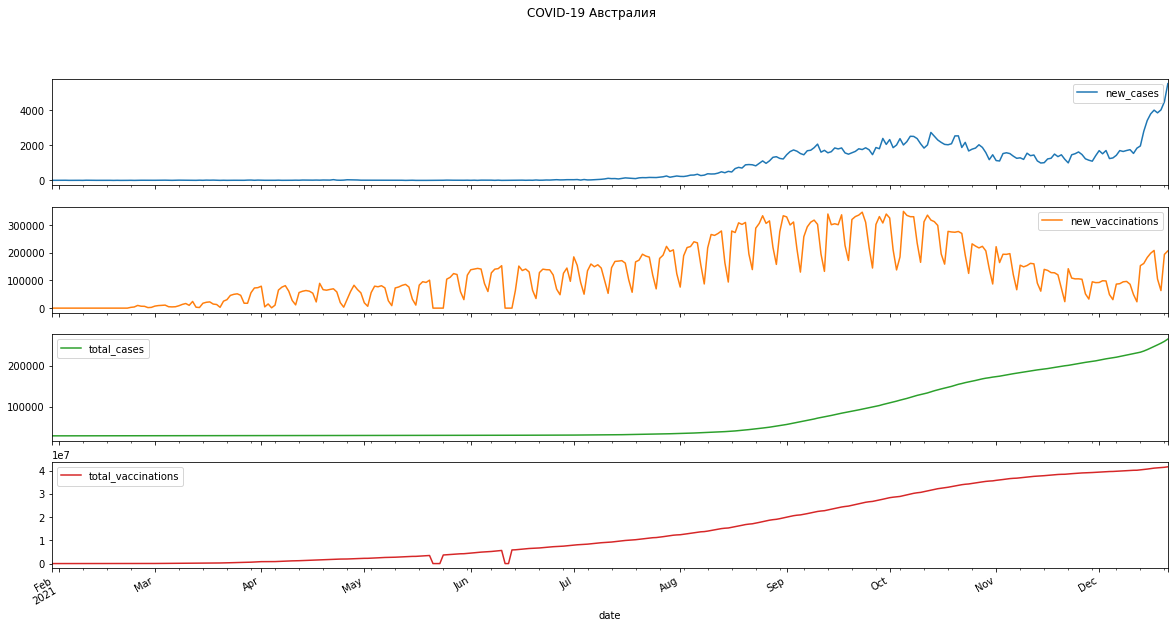

In [23]:
df_new[['new_cases', 'new_vaccinations', 'total_cases', 'total_vaccinations']].plot(subplots=True, figsize=(20, 10), title = 'COVID-19 Австралия');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6824cacd10>,
      dtype=object)

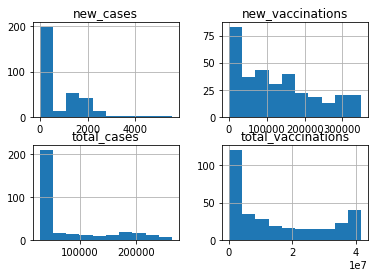

In [24]:
df_new.hist()

In [25]:
df_new.corr()

,new_cases,new_vaccinations,total_cases,total_vaccinations
new_cases,1.000000,0.594126,0.812388,0.863073
new_vaccinations,0.594126,1.000000,0.267001,0.538776
total_cases,0.812388,0.267001,1.000000,0.936117
total_vaccinations,0.863073,0.538776,0.936117,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



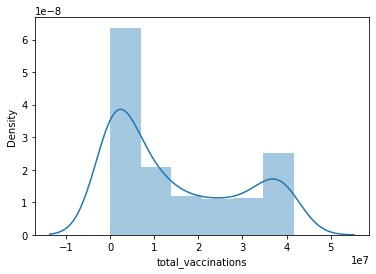

In [26]:
sns.distplot(df_new.total_vaccinations)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



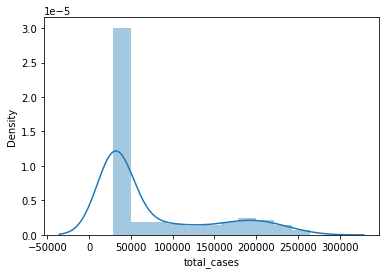

In [27]:
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



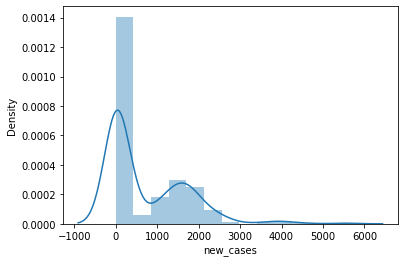

In [30]:
sns.distplot(df_new.new_cases)

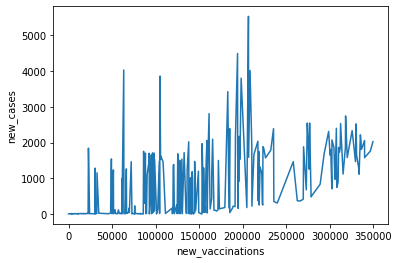

In [31]:
sns.lineplot(data = df_new, x = 'new_vaccinations', y = 'new_cases')

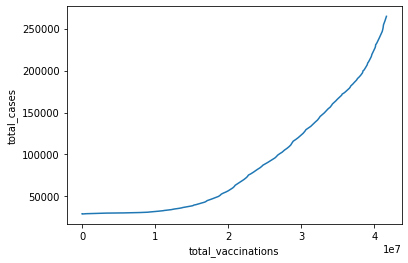

In [32]:
sns.lineplot(data = df_new, y = 'total_cases', x = 'total_vaccinations')

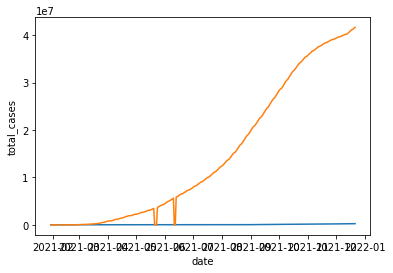

In [33]:
sns.lineplot(data = df_new, x = 'date', y = 'total_cases')
sns.lineplot(data = df_new, x = 'date', y = 'total_vaccinations')